# Stability analysis of model

Now the objective is to select the best model and to ensure its validity over time.

How can we evaluate our model choice ? This is the protocol I will follow for each of the selected amounts of time in months

1. Train the best model on the first period of time __m<sup>1</sup>__
2. Train the best model on the _n<sup>th</sup>_ periods of time __m<sup>th</sup>__
3. At each iteration, compare the clustering fit from __m<sup>1</sup>__ to __m<sup>th</sup>__ using ARI score
4. Plot and decide for which period of time the model is stable

Theses are the results of the experiments :

| Clustering   | Silhouette Score | Clusters | Model |
|--------------|------------------|----------|-------|
| KMeans       | 0.35             | 4        | RFM   |
| CAH          | 0.43             | 5        | RFM   |
| DBSCAN       | 0.64             | 2        | RFM   |
| KMeans       | 0.30             | 6        | RFMS  |
| K-Prototypes | 0.30             | 4        | RFMS  |
| DBSCAN       | 0.61             | 2        | RFMS  |
| CAH          | 0.34             | 2        | RFMS  |
| KMeans       | 0.35             | 7        | RMS   |
| DBSCAN       | 0.76             | 2        | RMS   |
| CAH          | 0.42             | 2        | RMS   |


From the experiments done until then, the best model is DBSCAN but we can't really work with 2 clusters, this is why we will chose CAH.

To filter by period, we will

In [202]:
import plotly.graph_objects as go


def plot_clusters_radars(df: pd.DataFrame):
    """
    Display a radar for every cluster

    :param df: the dataframe with the clusters
    :return: void
    """
    fig = go.Figure()

    for cluster in df["cluster"]:
        fig.add_trace(
            go.Scatterpolar(
                r=df[df["cluster"] == cluster].iloc[:, 1:].values.reshape(-1),
                theta=df.columns[1:],
                fill="toself",
                name="Cluster " + str(cluster),
            )
        )

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=True,
        title={
            "text": "Mean Comparison of Variables per Cluster",
            "y": 0.95,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        title_font_color="blue",
        title_font_size=18,
    )

    fig.show()

## 1 - Evaluating the stability of the model on monthly basis

In [203]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

customers = pd.read_csv(
    "./../output/rms.csv", parse_dates=["first_order", "last_order"]
)

customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,2,4,1,7,Bons clients,4.0,33.333333,Best Contributor
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,5,1,2,8,Bons clients,3.0,33.333333,Best Contributor
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,4,2,1,7,Bons clients,4.0,66.666667,Best Contributor
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,4,2,4,10,Bons clients,5.0,33.333333,Best Contributor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93103,447.0,0.062500,2067.42,1.0,2017-06-08 21:00:36,2017-06-08 21:00:36,0,5,1,5,11,Bons clients,5.0,33.333333,Best Contributor
93104,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,7,Bons clients,4.0,33.333333,Best Contributor
93105,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,5,1,3,9,Bons clients,5.0,33.333333,Best Contributor
93106,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor


First we need to segment the database into month pieces !

The dataset got its first order in September of 2016 and its last order in August of 2018, it's 25 months of data but data of these first month and last month are incomplete
so we will consider the period of time from October of 2016 to July of 2017.

In [204]:
min_order = customers["first_order"].min()

customers["month_group"] = 0
customers.loc[:, "months_since_first"] = (
    round((customers["first_order"] - min_order).dt.days / 30) + 1
)
customers["month_group"] = customers["months_since_first"].astype("int")

distributed_customers = customers.copy()

print(
    distributed_customers["first_order"].min(),
    distributed_customers["first_order"].max(),
)
print(sorted(distributed_customers["month_group"].unique()))

2016-09-15 12:16:38 2018-08-29 15:00:37
[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [205]:
# No orders on November 2016 ? WTF
distributed_customers[
    (distributed_customers.first_order.dt.year == 2016)
    & (distributed_customers.first_order.dt.month == 11)
]

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior,month_group,months_since_first


In [206]:
distributed_customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior,month_group,months_since_first
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor,21,21.0
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,2,4,1,7,Bons clients,4.0,33.333333,Best Contributor,21,21.0
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,5,1,2,8,Bons clients,3.0,33.333333,Best Contributor,7,7.0
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,4,2,1,7,Bons clients,4.0,66.666667,Best Contributor,14,14.0
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,4,2,4,10,Bons clients,5.0,33.333333,Best Contributor,15,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93103,447.0,0.062500,2067.42,1.0,2017-06-08 21:00:36,2017-06-08 21:00:36,0,5,1,5,11,Bons clients,5.0,33.333333,Best Contributor,10,10.0
93104,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,7,Bons clients,4.0,33.333333,Best Contributor,16,16.0
93105,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,5,1,3,9,Bons clients,5.0,33.333333,Best Contributor,6,6.0
93106,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor,21,21.0


In [207]:
in_period = (distributed_customers.first_order >= "2016-10-01") & (
    distributed_customers.first_order <= "2018-07-31"
)

distributed_customers = distributed_customers.loc[in_period, :]

# If the Second Order is out of range, replace it with the First Order date
out_of_period = (distributed_customers.last_order <= "2016-10-01") & (
    distributed_customers.last_order >= "2018-07-31"
)
distributed_customers.loc[out_of_period, "nb_orders"] = 1
distributed_customers.loc[out_of_period, "days_between_orders"] = 0
distributed_customers.loc[out_of_period, "last_order"] = distributed_customers[
    "first_order"
]

distributed_customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior,month_group,months_since_first
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor,21,21.0
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,2,4,1,7,Bons clients,4.0,33.333333,Best Contributor,21,21.0
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,5,1,2,8,Bons clients,3.0,33.333333,Best Contributor,7,7.0
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,4,2,1,7,Bons clients,4.0,66.666667,Best Contributor,14,14.0
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,4,2,4,10,Bons clients,5.0,33.333333,Best Contributor,15,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93103,447.0,0.062500,2067.42,1.0,2017-06-08 21:00:36,2017-06-08 21:00:36,0,5,1,5,11,Bons clients,5.0,33.333333,Best Contributor,10,10.0
93104,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,7,Bons clients,4.0,33.333333,Best Contributor,16,16.0
93105,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,5,1,3,9,Bons clients,5.0,33.333333,Best Contributor,6,6.0
93106,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor,21,21.0


In [208]:
distributed_customers

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior,month_group,months_since_first
0,112.0,0.200000,141.90,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor,21,21.0
1,115.0,0.200000,27.19,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,2,4,1,7,Bons clients,4.0,33.333333,Best Contributor,21,21.0
2,537.0,0.052632,86.22,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,0,5,1,2,8,Bons clients,3.0,33.333333,Best Contributor,7,7.0
3,321.0,0.083333,43.62,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,0,4,2,1,7,Bons clients,4.0,66.666667,Best Contributor,14,14.0
4,288.0,0.090909,196.89,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,0,4,2,4,10,Bons clients,5.0,33.333333,Best Contributor,15,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93103,447.0,0.062500,2067.42,1.0,2017-06-08 21:00:36,2017-06-08 21:00:36,0,5,1,5,11,Bons clients,5.0,33.333333,Best Contributor,10,10.0
93104,262.0,0.100000,84.58,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,0,3,2,2,7,Bons clients,4.0,33.333333,Best Contributor,16,16.0
93105,568.0,0.050000,112.46,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,0,5,1,3,9,Bons clients,5.0,33.333333,Best Contributor,6,6.0
93106,119.0,0.200000,133.69,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,0,2,4,4,10,Bons clients,5.0,100.000000,Best Contributor,21,21.0


In [209]:
distributed_customers.groupby("month_group").count()

,recency,frequency,monetary,nb_orders,first_order,last_order,days_between_orders,scoring_R,scoring_F,scoring_M,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior,months_since_first
month_group,,,,,,,,,,,,,,,,
2,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261,261
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,573,573,573,573,573,573,573,573,573,573,573,573,573,573,573,573
6,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
7,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453,2453
8,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167
9,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304,3304
10,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952,2952
11,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691


We need at least 20 000 customers to get a performant model so we will use the 13 first groups as basis for the model m<sup>1</sup>.

* To build m<sup>2</sup>, we will use the 14 first groups
* To build m<sup>3</sup>, we will use the 15 first groups
* etc ...

| Model          | Groups used  | Group Month of comparison for ARI |
|----------------|--------------|-----------------------------------|
| m<sup>1</sup>  | from 1 to 13 | _Not applicable_                  |
| m<sup>2</sup>  | from 1 to 14 | 14                                |
| m<sup>3</sup>  | from 1 to 15 | 15                                |
| m<sup>4</sup>  | from 1 to 16 | 16                                |
| m<sup>5</sup>  | from 1 to 17 | 17                                |
| m<sup>6</sup>  | from 1 to 18 | 18                                |
| m<sup>7</sup>  | from 1 to 19 | 19                                |
| m<sup>8</sup>  | from 1 to 20 | 20                                |
| m<sup>9</sup>  | from 1 to 21 | 21                                |
| m<sup>10</sup> | from 1 to 22 | 22                                |
| m<sup>11</sup> | from 1 to 23 | 23                                |
| m<sup>12</sup> | from 1 to 24 | 24                                |


## Preparation of the Dataset for training

In [210]:
distributed_customers = distributed_customers[
    ["recency", "frequency", "monetary", "month_group"]
].copy()

In [211]:
def get_trained_model(month_group, verbose=False):
    customers = distributed_customers.query("month_group <= @month_group")[
        ["recency", "frequency", "monetary"]
    ]

    if verbose:
        print(
            "Trained on {0} Customers until Group Month {1}".format(
                str(customers["recency"].count()), str(month_group)
            )
        )

    pipeline = make_pipeline(StandardScaler(), PowerTransformer())
    scaled_customers = pipeline.fit_transform(customers)

    return KMeans(n_clusters=6, random_state=42).fit(scaled_customers)


def predict_group_labels(trained_model, month_group, model_name, verbose=False):
    customers = distributed_customers.query("month_group <= @month_group")[
        ["recency", "frequency", "monetary"]
    ]

    if verbose:
        print(
            "Predict {0} Customers Labels for original group By {1}".format(
                str(customers["recency"].count()), model_name
            )
        )

    pipeline = make_pipeline(StandardScaler(), PowerTransformer())
    scaled_customers = pipeline.fit_transform(customers)

    return trained_model.predict(scaled_customers)

In [212]:
def get_ari_graph(months_of_training, verbose=False):

    print(
        "Number of Customers used to train the Basis model: {0}".format(
            str(
                distributed_customers.query("month_group <= @months_of_training").shape[
                    0
                ]
            )
        )
    )
    m1 = get_trained_model(months_of_training)
    true_labels = m1.labels_

    ari_scores = []

    for model in range(2, (25 - (months_of_training - 2))):
        group_month = model + (months_of_training - 1)
        # Train the model with the new data
        new_model = get_trained_model(group_month, verbose)

        # Get the predicted labels predicted by the new model
        predicted_labels = predict_group_labels(
            new_model, months_of_training, f"Model {group_month}", verbose
        )

        ari_scores.append(
            {
                "month": model - 1,
                "ari_score": adjusted_rand_score(true_labels, predicted_labels),
            }
        )

    pd.DataFrame(ari_scores).plot(
        title="Evolution of ARI Score per Month", x="month", y="ari_score"
    );

In [ ]:
# Create the DataFrame of ARI Scores (~25k of Customers)

get_ari_graph(13)

Number of Customers used to train the Basis model: 24909


The evolution of ARI Score show that the performance decrease a lot after 6 months, but we had only 20k customers : what if we collect more customers ?

Number of Customers used to train the Basis model: 47451


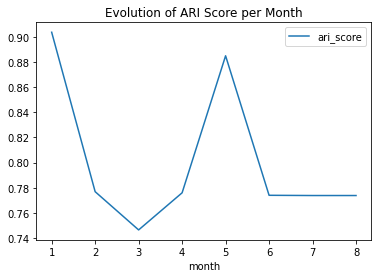

In [214]:
# Create the DataFrame of ARI Scores (~45k of Customers)

get_ari_graph(17)

After 6 months, we see the decrease of ARI Score.